Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
import warnings
warnings.filterwarnings('ignore')

Load Data

In [2]:
data = pd.read_csv('C:/Users/Godwin/Documents/Workflow/ML Zoomcamp/Classification/Califonia Housing Data/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Data Preparation

In [3]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

categorical_col = data.dtypes[data.dtypes == 'object'].index.tolist()
for col in categorical_col:
    data[col] = data[col].str.replace(' ', '_').str.lower()

In [4]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
data.fillna(0, inplace = True)

In [6]:
data['rooms_per_household'] = data['total_rooms']/ data['households']
data['bedrooms_per_room'] = data['total_bedrooms']/data['total_rooms']
data['population_per_household'] = data['population']/ data['households']

In [7]:
data['ocean_proximity'].value_counts().head()

<1h_ocean     9136
inland        6551
near_ocean    2658
near_bay      2290
island           5
Name: ocean_proximity, dtype: int64

Visualizing Correlation

<AxesSubplot: >

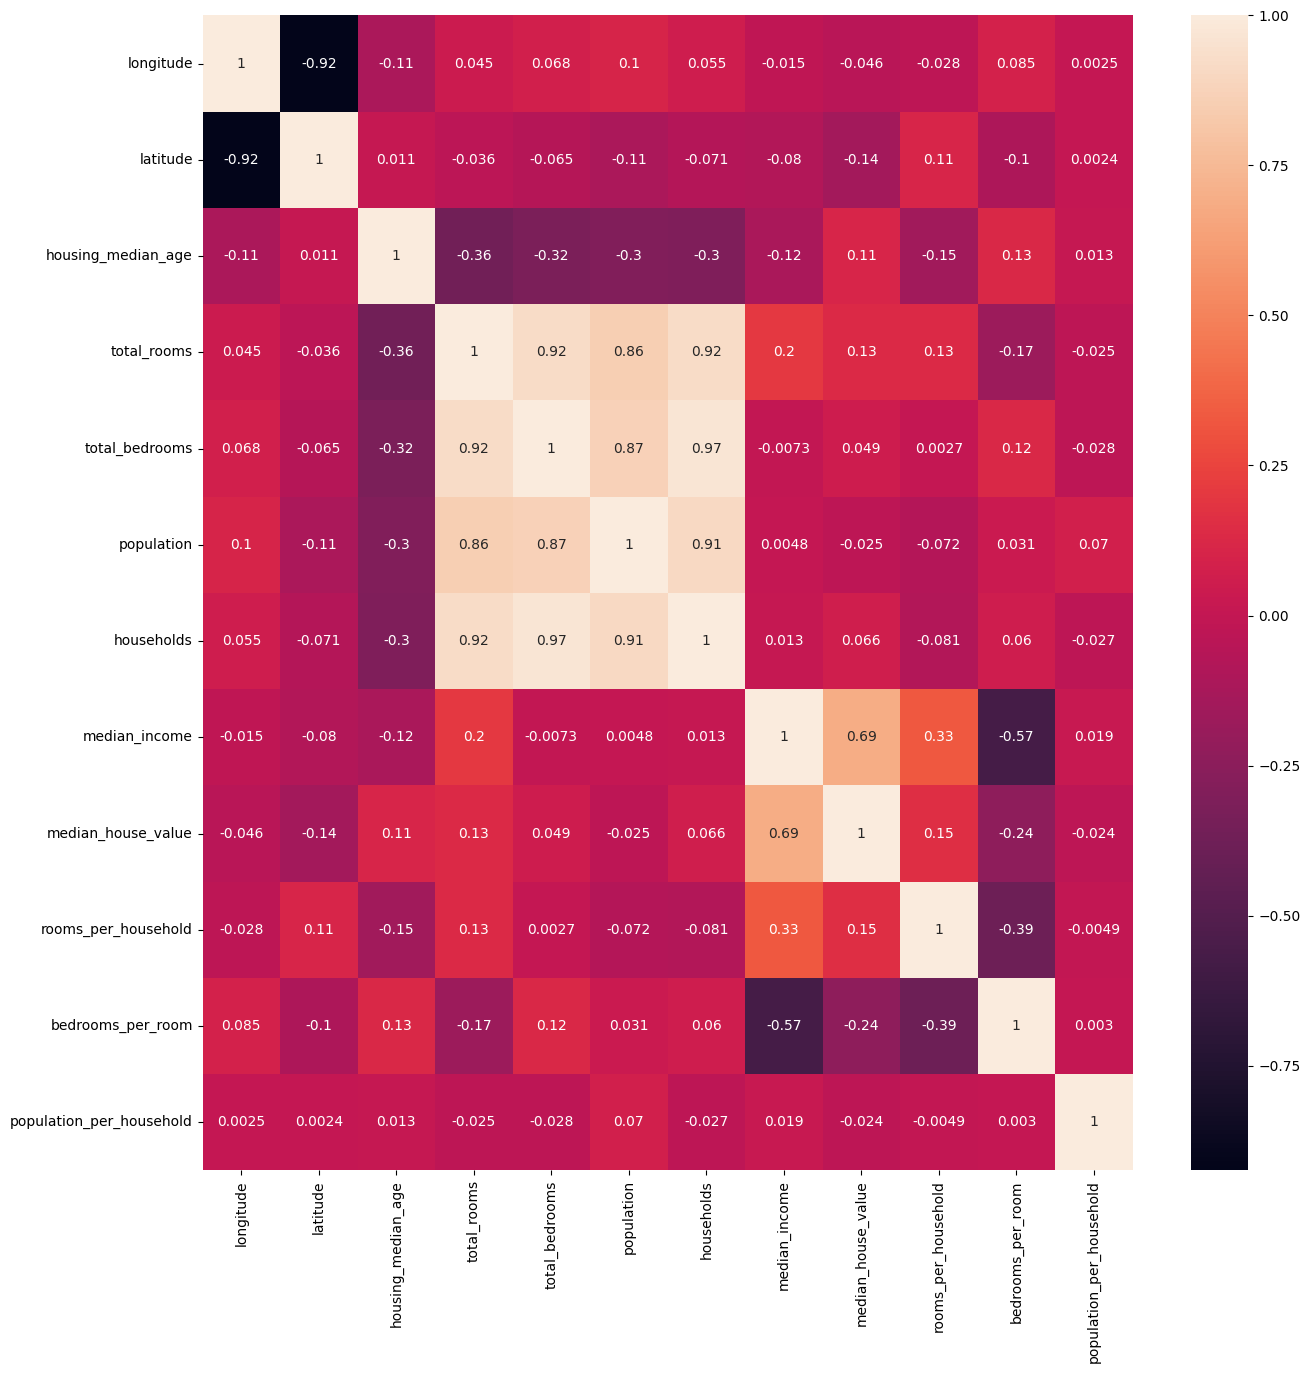

In [8]:
plt.figure(figsize=(15,15))
#Numerical feature correlation
corr = data.corr(method = 'pearson')

#plotting correlation
sns.heatmap(corr, annot = True)

From the plot it shows that 'total_bedromom' and 'total rooms', 'total_bedromom' and 'poulation', 'total_bedromom' and 'total rooms' and few others are highly correlated

In [9]:
mean_value = data['median_house_value'].mean()
new_df = data.copy()

#Creating binary target column
new_df['above_average'] = (data['median_house_value'] > mean_value).astype('int')
del new_df['median_house_value']

In [10]:
#Splitting the data
train_df, test_df = train_test_split(new_df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state = 42)

y_train = train_df.pop('above_average')
y_test = test_df.pop('above_average')
y_val = val_df.pop('above_average')

In [11]:
categorical_col = train_df.dtypes[train_df.dtypes == 'object'].index.to_list()
numerical_col = train_df.dtypes[train_df.dtypes != 'object'].index.to_list()

#Vetorizing data
dv = DictVectorizer(sparse = False)
dv.fit(train_df[numerical_col + categorical_col].to_dict(orient = 'records'))
names = dv.get_feature_names()

X_train = dv.transform(train_df[numerical_col + categorical_col].to_dict(orient = 'records'))
X_test = dv.transform(test_df[numerical_col + categorical_col].to_dict(orient = 'records'))
X_val = dv.transform(val_df[numerical_col + categorical_col].to_dict(orient = 'records'))

In [12]:
#Training the model
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

#Model Accuracy
prediction = model.predict_proba(X_val)[:, 1]
decision = (prediction >=0.5)
accuracy = round((y_val == decision).mean(), 2)
print('The baseline accuracy is ',accuracy)

The baseline accuracy is  0.84


Checking accuracy of model without a feature

In [13]:
full_col = categorical_col + numerical_col

feature = []
global_acc = []
diff = []
for col in full_col:
    new_col = [i for i in full_col if i != col]
    X_train = dv.transform(train_df[new_col].to_dict(orient = 'records'))
    X_val = dv.transform(val_df[new_col].to_dict(orient = 'records'))

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    prediction = model.predict_proba(X_val)[:, 1]
    decision = (prediction >=0.5)
    new_acc = round((y_val == decision).mean(), 5)
    global_acc.append(new_acc)
    feature.append(col)
    diff.append(round((accuracy - new_acc), 5))

out = pd.DataFrame({'Feature':feature, 'Accuracy_score': global_acc, 'Difference': diff})
out.sort_values(by = ['Difference']).reset_index(drop = True)

,Feature,Accuracy_score,Difference
0,total_bedrooms,0.83769,0.00231
1,total_rooms,0.83721,0.00279
2,rooms_per_household,0.83648,0.00352
3,bedrooms_per_room,0.83624,0.00376
4,population_per_household,0.83576,0.00424
5,latitude,0.83406,0.00594
6,households,0.83285,0.00715
7,longitude,0.83212,0.00788
8,housing_median_age,0.82946,0.01054
9,population,0.82631,0.01369


Linear Regression

In [14]:
#DAta Preparation
new_df = data.copy()

train_df, test_df = train_test_split(new_df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state = 42)

#Transforming target variable
y_train = np.log1p(train_df.pop('median_house_value'))
y_test = np.log1p(test_df.pop('median_house_value'))
y_val = np.log1p(val_df.pop('median_house_value'))

dv.fit(train_df[numerical_col + categorical_col].to_dict(orient = 'records'))
names = dv.get_feature_names()

X_train = dv.transform(train_df[numerical_col + categorical_col].to_dict(orient = 'records'))
X_test = dv.transform(test_df[numerical_col + categorical_col].to_dict(orient = 'records'))
X_val = dv.transform(val_df[numerical_col + categorical_col].to_dict(orient = 'records'))

In [15]:
def rmse(actual, predicted):
    error = actual - predicted
    rms = np.square(error)
    rms = np.mean(rms)
    return np.sqrt(rms)

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_val)
error = rmse(y_val, prediction)
print('The erro using a linear regression model is ', error)

The erro using a linear regression model is  0.32449078550856436


In [17]:
def rmse(actual, predicted):
    '''Returns root mean squared error'''
    error = actual - predicted
    rms = np.square(error)
    rms = np.mean(rms)
    return np.sqrt(rms)

#Training Model with different alpha
alpha_value = [0, 0.01, 0.1, 1, 10]
errors = []
for a in alpha_value:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    error = round(rmse(y_val, prediction), 3)
    errors.append(error)

output = pd.DataFrame({'Alpha Value': alpha_value, 'Error': errors})

In [18]:
output.head()

,Alpha Value,Error
0,0.00,0.524
1,0.01,0.524
2,0.10,0.524
3,1.00,0.524
4,10.00,0.524


The accuracy score of Linear Regression is better than that of Ridge Regression for all differt alpha values